In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt


# Data paths
train_data_dir = 'D:/DATASET/CNN/inflammation/train'
validation_data_dir = 'D:/DATASET/CNN/inflammation/val'

# Image dimensions
img_height, img_width = 299, 299
input_shape = (img_height, img_width, 3)

# Parameters
batch_size = 32
num_classes = 3

In [ ]:
# Data Augmentation and Normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and Augment Data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


In [ ]:
# Create ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

In [ ]:
# Evaluation
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

In [2]:
# Load the model using TensorFlow's built-in method
model = tf.keras.models.load_model('D:/DATASET/Models/model_inflammation.h5')


In [8]:
import matplotlib.image as mpimg

def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

In [9]:
# Prediction
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    predictions = model.predict(img_array)
    score = np.argmax(predictions)
    if score == 0:
        print("NASH Score: 0 - No inflammatory foci per 200×field")
    elif score == 1:
        print("NASH Score: 1 - <2 foci or 2-4 foci per 200×field")
    elif score == 2:
        print("NASH Score: 2 - >4 foci per 200×field")


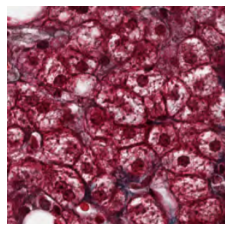

1/1 [==============================] - 0s 223ms/step
NASH Score: 2 - >4 foci per 200×field


In [11]:
# Example prediction
image_path = "D:/DATASET/CNN/inflammation/train/0/322_64_28.png"
show_image(image_path)
predict_image(image_path)